In [1]:
import numpy as np
import pandas as pd
# for HTTP requests from API
import requests
# to interact with OS, like creating directories, checking for file
import os
import json
import time
# file searching by matching file paths based on specified pattern
from glob import glob
from datetime import datetime, timedelta
from urllib.parse import quote # encode a URL query string by escaping special characters
from tqdm.notebook import tqdm # Provides a progress bar for loops
import matplotlib.pyplot as plt

In [2]:
# Variables
api_key = '4c3dabc77ad148ae820234309251501'
city = 'Goa'
start_date = datetime.strptime('2008-08-01', '%Y-%m-%d')
end_date = datetime.strptime('2009-08-01', '%Y-%m-%d')
frequency = '1' # Hourly

In [3]:
# Function to generate pairs of start and end dates for each month
def generate_month_ranges(start, end):
    current = start
    while current <= end:
        month_end = (current.replace(day=28) + timedelta(days=4)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        yield current, month_end
        current = month_end + timedelta(days=1)

In [5]:
# Ensure the directory exists if not make one
os.makedirs('./data', exist_ok=True)

In [6]:
# Loop through each month and download data with progress bar
for start, end in tqdm(generate_month_ranges(start_date, end_date), desc="Downloading data"):
    file_path = f'./data/weather_{city}_{start.strftime("%Y_%m")}.json'

    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"File for {start.strftime('%Y-%m')} already exists. Skipping download.")
        continue
    # making request
    encoded_city = quote(city)
    url = (f'http://api.worldweatheronline.com/premium/v1/past-weather.ashx'
           f'?key={api_key}&q={encoded_city}&format=json&date={start.strftime("%Y-%m-%d")}'
           f'&enddate={end.strftime("%Y-%m-%d")}&tp={frequency}')

    print(f"Starting download for {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}...")

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP errors
        monthly_data = response.json()

        # Check if 'data' and 'weather' keys are present
        if 'data' in monthly_data and 'weather' in monthly_data['data']:
            with open(file_path, 'w') as f:
                json.dump(monthly_data, f)
            print(f"Saved data for {start.strftime('%Y-%m')}")
        else:
            print(f"Unexpected structure for {start.strftime('%Y-%m')}: Missing 'weather' key")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {start.strftime('%Y-%m')}: {e}")

    time.sleep(1)  # Sleep to avoid hitting rate limits

print("Data download complete.")

Starting download for 2008-08 to 2008-08...
Saved data for 2008-08
Starting download for 2008-09 to 2008-09...
Saved data for 2008-09
Starting download for 2008-10 to 2008-10...
Saved data for 2008-10
Starting download for 2008-11 to 2008-11...
Saved data for 2008-11
Starting download for 2008-12 to 2008-12...
Saved data for 2008-12
Starting download for 2009-01 to 2009-01...
Saved data for 2009-01
Starting download for 2009-02 to 2009-02...
Saved data for 2009-02
Starting download for 2009-03 to 2009-03...
Saved data for 2009-03
Starting download for 2009-04 to 2009-04...
Saved data for 2009-04
Starting download for 2009-05 to 2009-05...
Saved data for 2009-05
Starting download for 2009-06 to 2009-06...
Saved data for 2009-06
Starting download for 2009-07 to 2009-07...
Saved data for 2009-07
Starting download for 2009-08 to 2009-08...
Saved data for 2009-08
Data download complete.


In [7]:
# Combine all weather data into one JSON
combined_data = []

# Loop through each file
for filename in glob('./data/weather_*.json'):
    with open(filename, 'r') as file:
        data = json.load(file)
        try:
            if 'data' in data and 'weather' in data['data']:
                combined_data.extend(data['data']['weather'])
            else:
                print(f"KeyError for {filename}: Missing 'weather' key")
        except KeyError as e:
            print(f"KeyError for {filename}: {e}")

# Save the combined data
output_filename = './data/combined_weather_data.json'
with open(output_filename, 'w') as outfile:
    json.dump({'data': {'weather': combined_data}}, outfile, indent=4)

print(f'All weather data has been combined and saved to {output_filename}')

All weather data has been combined and saved to ./data/combined_weather_data.json


In [8]:
# Load the combined JSON data
with open('./data/combined_weather_data.json', 'r') as file:
    combined_data = json.load(file)

# Extract the hourly data
hourly_data_list = []

for weather_day in combined_data['data']['weather']:
    date = weather_day['date']
    for hourly_data in weather_day['hourly']:
        # Flatten the hourly data and add the date to each entry
        hourly_data_flattened = {
            'date_time': f"{date} {int(hourly_data['time'])//100:02d}:00",  # Combines date and time
            'tempC': hourly_data['tempC'],
            'humidity': hourly_data['humidity'],
            'pressure': hourly_data['pressure'],
            'precipMM': hourly_data['precipMM'],
            'uvIndex': hourly_data['uvIndex'],
            'windspeedKmph': hourly_data['windspeedKmph'],
            'winddirDegree': hourly_data['winddirDegree'],
            'weatherDesc': hourly_data['weatherDesc'][0]['value'],  # Assumes first description is primary
        }
        hourly_data_list.append(hourly_data_flattened)

# Create a pandas DataFrame from the list of dictionaries
hourly_df = pd.DataFrame(hourly_data_list)

# Convert columns to numeric, if possible
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']
hourly_df[numeric_cols] = hourly_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert the 'date_time' column to datetime
hourly_df['date_time'] = pd.to_datetime(hourly_df['date_time'], format='%Y-%m-%d %H:%M')

# Set the 'date_time' as the index of the DataFrame
hourly_df.set_index('date_time', inplace=True)

# Save the DataFrame to a CSV file
csv_file_path = './data/weather_data_goa_hourly.csv'
hourly_df.to_csv(csv_file_path, index=True)

print(f'Hourly weather data saved to CSV file at: {csv_file_path}')

# Now hourly_df is a pandas DataFrame containing all the hourly data

Hourly weather data saved to CSV file at: ./data/weather_data_goa_hourly.csv


In [9]:
# Sort the DataFrame by date_time
hourly_df.sort_values(by='date_time', inplace=True)

In [10]:
hourly_df

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
date_time,,,,,,,,
2008-08-01 00:00:00,23,97,1019,0.0,1,4,119,Clear
2008-08-01 01:00:00,23,97,1018,0.0,1,3,173,Partly cloudy
2008-08-01 02:00:00,22,97,1018,0.0,1,2,226,Cloudy
2008-08-01 03:00:00,22,97,1018,0.0,1,1,280,Overcast
2008-08-01 04:00:00,22,95,1018,0.0,1,2,251,Cloudy
...,...,...,...,...,...,...,...,...
2009-08-01 19:00:00,27,83,1015,0.0,1,7,182,Clear
2009-08-01 20:00:00,25,87,1015,0.0,1,6,185,Clear
2009-08-01 21:00:00,24,91,1015,0.0,1,5,188,Partly cloudy


In [11]:
hourly_df.isna().sum()

,0
tempC,0
humidity,0
pressure,0
precipMM,0
uvIndex,0
windspeedKmph,0
winddirDegree,0
weatherDesc,0


In [12]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2008-08-01 00:00:00 to 2009-08-01 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tempC          8784 non-null   int64  
 1   humidity       8784 non-null   int64  
 2   pressure       8784 non-null   int64  
 3   precipMM       8784 non-null   float64
 4   uvIndex        8784 non-null   int64  
 5   windspeedKmph  8784 non-null   int64  
 6   winddirDegree  8784 non-null   int64  
 7   weatherDesc    8784 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 617.6+ KB


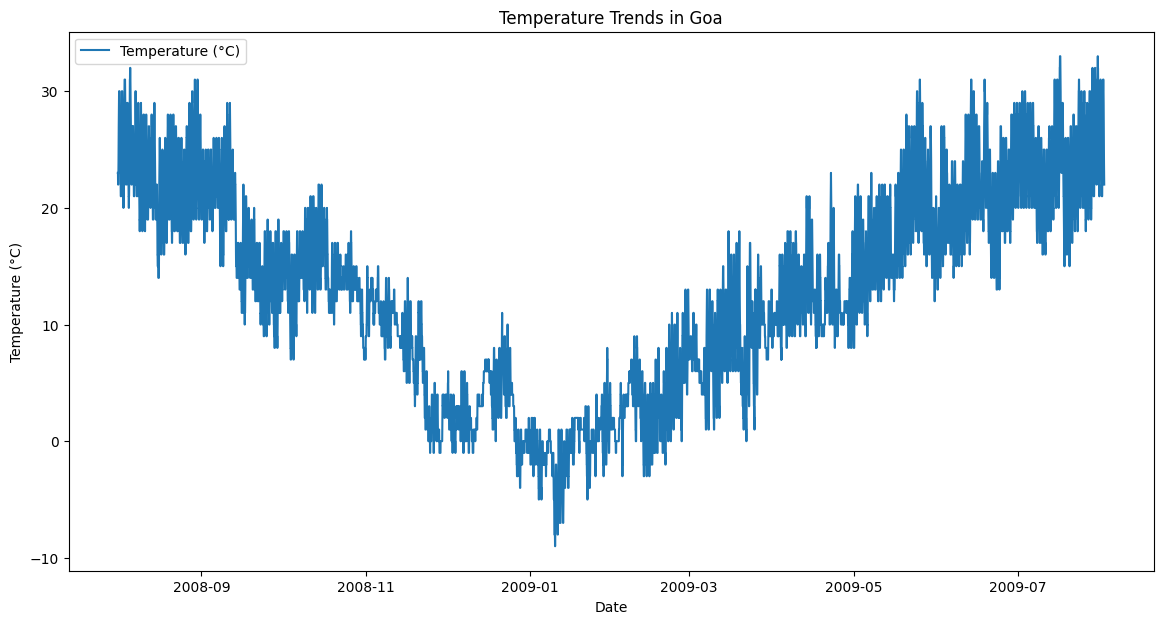

In [15]:
# Temperature Trends Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['tempC'], label='Temperature (°C)')
plt.title('Temperature Trends in Goa')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

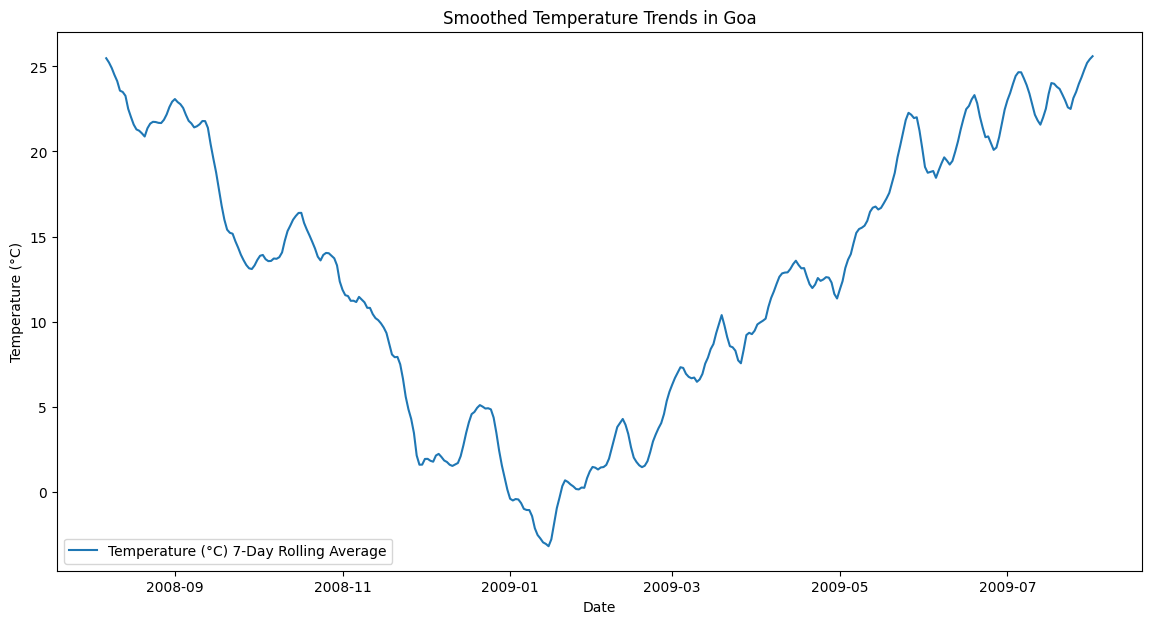

In [17]:
# We should resample and calculate the mean for the numeric columns only
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']

# Non-numeric columns will be excluded
df_daily = hourly_df[numeric_cols].resample('D').mean()

# Calculate a 7-day rolling average for temperature
df_daily['tempC_rolling'] = df_daily['tempC'].rolling(window=7).mean()

# Plot the rolling average temperature
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='Temperature (°C) 7-Day Rolling Average')
plt.title('Smoothed Temperature Trends in Goa')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Trend line on the daily mean temperature

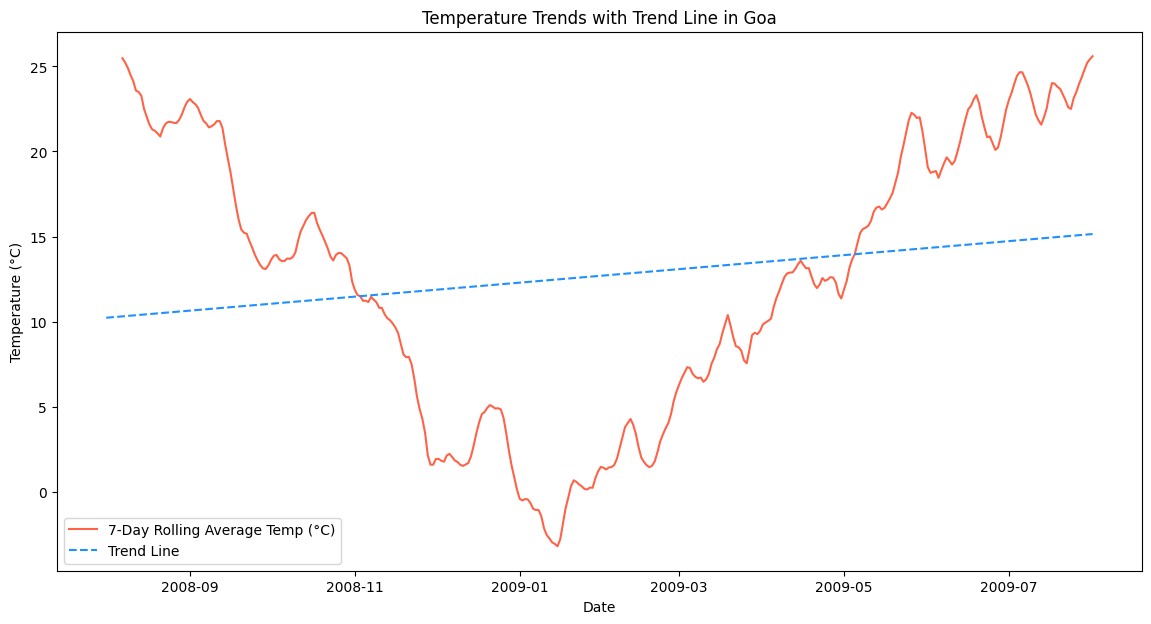

In [18]:
# Fit a simple linear regression (trend line) on the daily mean temperature
# First, we need to create a series of ordinal date numbers for regression
df_daily['date_ordinal'] = df_daily.index.map(pd.Timestamp.toordinal)

# Then, use numpy's polyfit to fit a first degree polynomial (linear)
# The polyfit function returns the coefficients for the equation of the line
coefficients = np.polyfit(df_daily['date_ordinal'], df_daily['tempC'], 1)

# Use the coefficients to create the equation of the line
polynomial = np.poly1d(coefficients)

# Now we can create y-values for our trend line based on the date ordinals
df_daily['trend_line'] = polynomial(df_daily['date_ordinal'])

#Plotting the temperature and trend line
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='7-Day Rolling Average Temp (°C)', color='tomato')
plt.plot(df_daily.index, df_daily['trend_line'], label='Trend Line', color='dodgerblue', linestyle='--')
plt.title('Temperature Trends with Trend Line in Goa')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

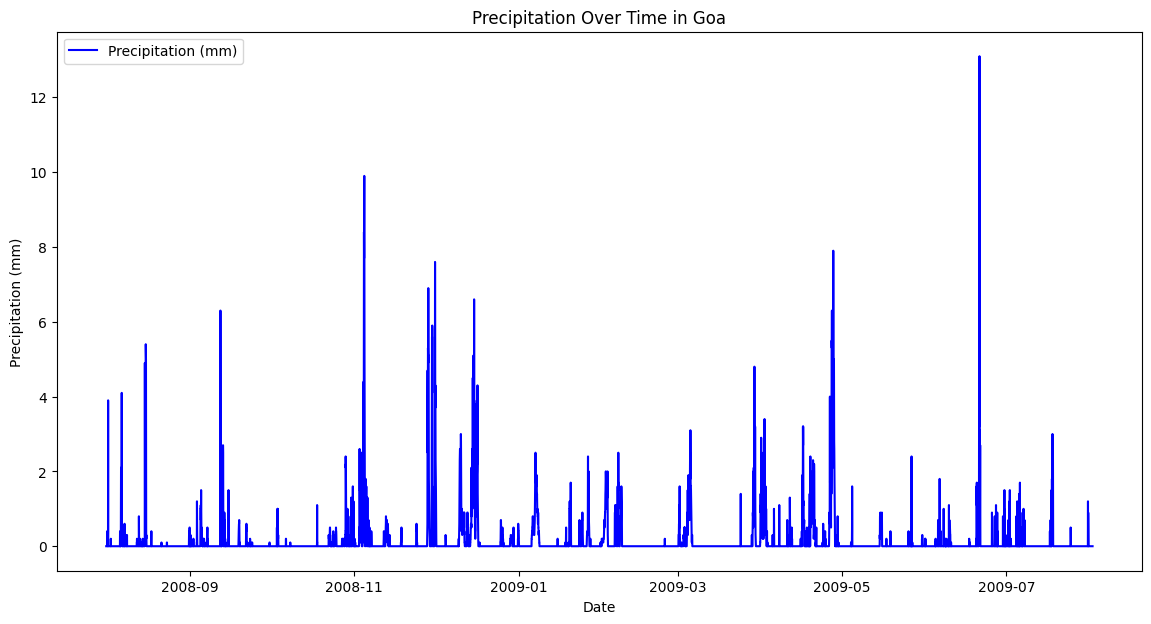

In [19]:
# Precipitation Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['precipMM'], label='Precipitation (mm)', color='blue')
plt.title('Precipitation Over Time in Goa')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

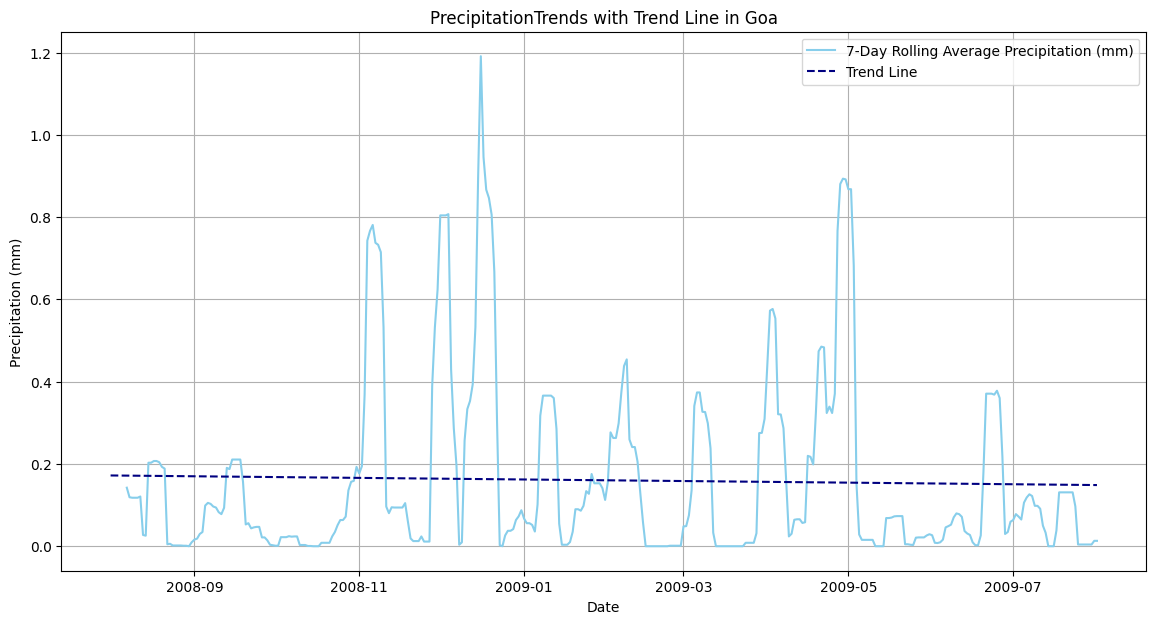

In [20]:
# Calculate a 7-day rolling average for precipitation
df_daily['precipMM_rolling'] = df_daily['precipMM'].rolling(window=7).mean()

# Fit a simple linear regression (trend line) on the daily mean precipitation
df_daily['date_ordinal'] = df_daily.index.map(pd.Timestamp.toordinal)
coefficients = np.polyfit(df_daily['date_ordinal'], df_daily['precipMM'], 1)
polynomial = np.poly1d(coefficients)
df_daily['trend_line'] = polynomial(df_daily['date_ordinal'])

# Plotting the rolling average of precipitation with a trend line
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['precipMM_rolling'], label='7-Day Rolling Average Precipitation (mm)', color='skyblue')
plt.plot(df_daily.index, df_daily['trend_line'], label='Trend Line', color='navy', linestyle='--')
plt.title('PrecipitationTrends with Trend Line in Goa')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()

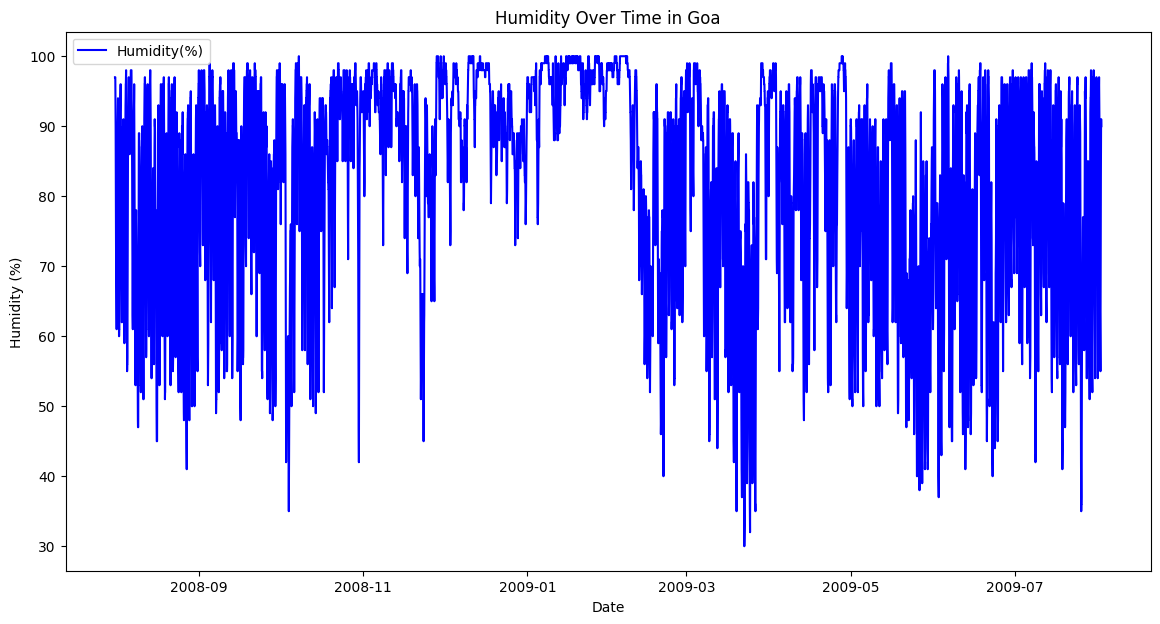

In [21]:
# Precipitation Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['humidity'], label='Humidity(%)', color='blue')
plt.title('Humidity Over Time in Goa')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.legend()
plt.show()